# Imports

In [74]:
import requests
import json
import folium
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, cut_tree
import matplotlib.pyplot as plt
import pandas as pd
import overpy
import os
import alphashape
import shapely
from matplotlib.patches import Polygon

# 1. Fetch Data

## 1.1.Data preprocessing

Using [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) to query locations that fulfill the given conditions.

In [75]:
api = overpy.Overpass()

# Query for all gas stations that are at less than road_distance=2km
# From a road classified as "autovía" (i.e motorway) in location=Granada
# Some other options for locations="Albacete, Galicia, Sevilla"

location = "Granada"
road_distance = "2000"  # (m)

query = '''
[out:json];
area[name='''+ location + '''][admin_level=8]->.where;
node(area.where)[highway=bus_stop];
out body;
>;
out skel qt;'''


# Selectin ALL amenities
query = '''
[out:json];
area[name='''+ location + '''][admin_level=8]->.granada;
(
  node(area.granada)[amenity](37.120, -3.650, 37.300, -3.570);
);
out body;
>;
out skel qt;
'''

response = api.query(query)

In [76]:
# Preparing the dataframe [id,latitude,longitude]
df = pd.DataFrame(
    columns=["id","lat","lon"])

for node in response.get_nodes():
    # Adding all the position information of nodes
    new_row = pd.DataFrame(
        {"id": node.id,
         "lat": node.lat,
         "lon": node.lon},
         index=[0])

    df = pd.concat([df,new_row],axis=0)

# Formatted information into a DataFrame, only for convenience
df.reset_index(inplace=True, drop=True)
print(df)

               id         lat         lon
0        83533572  37.1868974  -3.6036270
1        88144037  37.1946846  -3.6228425
2       267489671  37.1868624  -3.5919396
3       290912866  37.2016761  -3.6155480
4       290969327  37.1741866  -3.5852181
...           ...         ...         ...
5273  12613054505  37.1714093  -3.5970657
5274  12613072801  37.1750674  -3.5976729
5275  12613072802  37.1736029  -3.5982325
5276  12613073001  37.1733682  -3.5975351
5277  12618982989  37.1780865  -3.6092263

[5278 rows x 3 columns]


Number of detected possible places: 5278


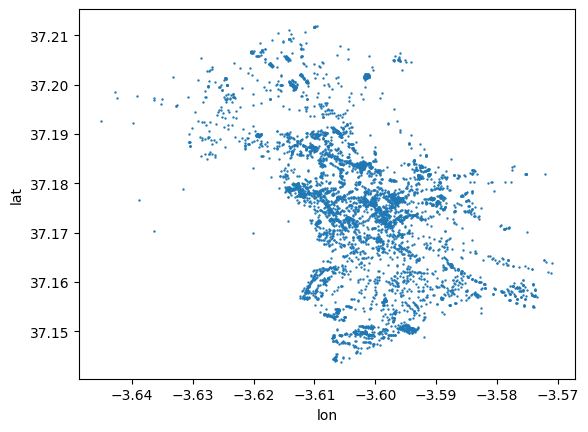

In [77]:
plt.scatter(x=df["lon"],y=df["lat"], s=0.5)
plt.xlabel("lon")
plt.ylabel("lat")
print("Number of detected possible places:", len(df.index))

## 1.2.Algorithm

Preprocessing: We will be using a clustering algorithm to non-unformlly sample the bus stops. The closer bus stops will be undersampled and the farther away from each other oversampled with respect to each other

## 1.1.Data preprocessing

Text(0.5, 1.0, 'Kmeans')

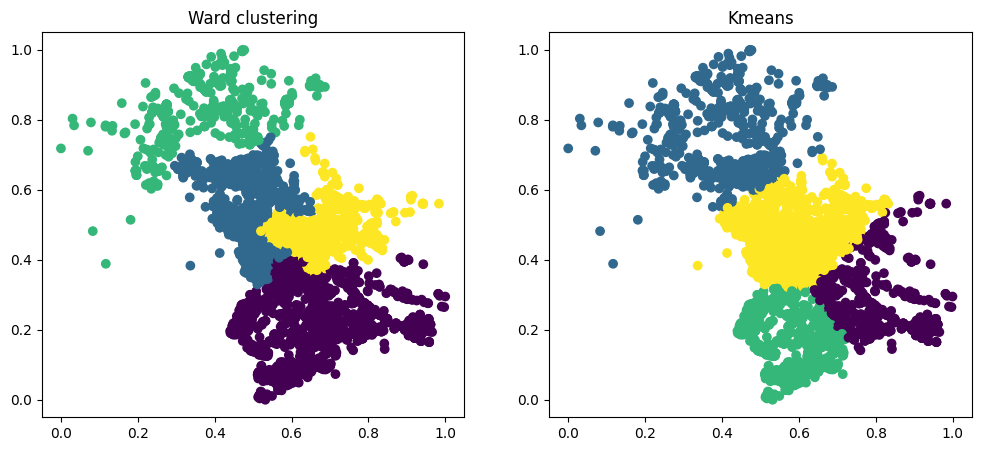

In [78]:
data_size = len(df.index)
# Normalizing data for epsilon selection

clusters = 4
min_cluster_size = int(data_size/clusters) # Min 1/40 per cluster
max_cluster_size = int(data_size/20) # Min 30 groups
min_samples = 10
epsilon = 0.0
clustering_agg = AgglomerativeClustering(n_clusters=clusters, linkage='ward', compute_distances=True)
scaler = MinMaxScaler()
X = scaler.fit_transform(df[['lon','lat']].values)


fig, ax = plt.subplots(1, 2)
fig.set_size_inches((12,5))

model_agg = clustering_agg.fit(X)
agg_labels = model_agg.labels_
ax[0].scatter(X.T[0], X.T[1], c=agg_labels)
ax[0].set_title('Ward clustering')

clustering = KMeans(clusters)
labels = clustering.fit_predict(X)

ax[1].scatter(X.T[0], X.T[1], c=labels)
ax[1].set_title('Kmeans')

In [79]:
class linkageCut:
    def __init__(self, data):
        self.data = data
        self.linkage_matrix = linkage(data, method='ward')
        self.tree_cut = cut_tree(self.linkage_matrix)
        
    def give_tree_cut(self):
        return self.tree_cut
    
    def __nunique(self, a, axis):
        ''' Count the number of unique elements in an array and axis'''
        return (np.diff(np.sort(a,axis=axis),axis=axis)!=0).sum(axis=axis)+1

    def recursive_down(self, n_clusters, level, total_levels, mask):
        if len(str(level)) < total_levels:
            
            # Selecting specific parent cluster
            small_tree = self.tree_cut[mask]
            
            # Checking how many subclusters there are in the parent cluster for each step in
            # the clustering (ward) process
            small_tree_nclusters = self.__nunique(small_tree, axis=0)
            
            try:
                # This is the step where there are exactly n_clusters subclusters
                sub_tree_step = np.where(small_tree_nclusters == n_clusters)[0][-1]
            except:
                raise Exception("Some cluster cannot be further divided")
            # Now we truly have the subdivision
            
            counter = 1
            for sub_lbl in np.unique(small_tree[:,sub_tree_step]):
                # Now we prepare the mask for each subcluster and the recursion
                sub_data_mask = np.where(self.tree_cut[:, sub_tree_step] == sub_lbl)[0]
                write = self.recursive_down( 
                                   n_clusters, int(str(level) + str(counter)), total_levels,
                                   sub_data_mask)
                if write == None:
                    write = str(level) + str(counter)
                self.top_down[sub_data_mask, len(str(level))] = int(write)
                counter+=1
                
            return None
        else:
            return level
        
    def top_down_view_recur(self, n_clusters, levels=1):
        ''' Constructs a top down view in which each cluster is
        subsequently divided in 'n_clusters'. This process 
        is iterated 'level' times.
        In each step, all data is labelled accordingly.
        
        The naming conventions for the labels is 1,2, ..., n_clusters for 
        the first level, 11 for the first subcluster of cluster 1 and so on. Example:
        
        132 has 3 levels, in the order 1(top)-3(middle)-2(lowest)
        
        :return: len_data x level matrix 
        '''
        
        # First level
        if levels < 1:
            raise Exception("levels must be greater or equal to 1") 
        
        # The first level is, by definition, in the tree_cut indx
        # len_data - n_clusters 
        self.top_down = np.zeros((len(self.data), levels))
                          
        tree_step = len(self.tree_cut) - n_clusters
        first_lbls = np.unique(self.tree_cut[:, tree_step])
        
        # Second level
        for lbl in first_lbls:
            data_mask = np.where(self.tree_cut[:, tree_step] == lbl)[0]
            self.top_down[data_mask, 0] = lbl + 1
            self.recursive_down(n_clusters, lbl + 1, levels, data_mask)
            
        return self.top_down
        
df = df.reset_index()
linkage_matrix = linkageCut(X)
top_down = linkage_matrix.top_down_view_recur(4, 3)

print("labels", np.unique(top_down))

labels [  1.   2.   3.   4.  11.  12.  13.  14.  21.  22.  23.  24.  31.  32.
  33.  34.  41.  42.  43.  44. 111. 112. 113. 114. 121. 122. 123. 124.
 131. 132. 133. 134. 141. 142. 143. 144. 211. 212. 213. 214. 221. 222.
 223. 224. 231. 232. 233. 234. 241. 242. 243. 244. 311. 312. 313. 314.
 321. 322. 323. 324. 331. 332. 333. 334. 341. 342. 343. 344. 411. 412.
 413. 414. 421. 422. 423. 424. 431. 432. 433. 434. 441. 442. 443. 444.]


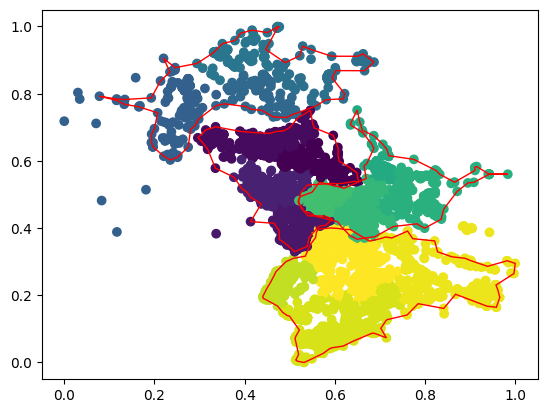

In [80]:
# fancy scatter
fig, ax = plt.subplots()
n_clusters = 4

x = X[:, 0]
y = X[:, 1]
z = top_down[:,1]
plt.scatter(X[:,0], X[:,1], c=top_down[:,1])
for i in range(1,n_clusters+1):
    cluster = X[top_down[:,0] == i]
    alpha = 30
    hull = alphashape.alphashape(cluster, alpha)
    if type(hull)== shapely.geometry.multipolygon.MultiPolygon:
        areas = [ geom.area for geom in hull.geoms]
        # Select the component with larger area
        big = np.argmax(areas)
        hull_pts = hull.geoms[big].exterior.coords.xy
    else:
        hull_pts = hull.exterior.coords.xy
    poly_patch = Polygon(np.array(hull_pts).T, facecolor='none', edgecolor='red')
    ax.add_patch(poly_patch)

plt.show()

In [81]:
def sample_data(df, labels, seed = 140421):
  np.random.seed(seed)
  # We extract n samples from each cluster
  unique_labels = np.unique(labels)
  # first position is reserved for nonassigned data
  n_cluster = np.zeros(len(unique_labels))
  indices = np.indices(labels.shape)[0]
  cluster_indices = []
  max_cluster_size = int(100/len(unique_labels))

  sample_indx = []

  for i in range(len(unique_labels)):
    filter_labels = labels == unique_labels[i]
    cluster_indices = indices[filter_labels]
    n_cluster[i] = len(cluster_indices)

    # Now we sample max_cluster_size
    extract_size = np.amin([max_cluster_size, n_cluster[i]]).astype(int)
    sample_indx.extend(np.random.choice(cluster_indices, size=extract_size, replace=False))


  final_data = pd.DataFrame(df.to_numpy()[sample_indx], columns=["index", 'id', 'lat', 'lon'])
  return final_data

final_data = sample_data(df, labels)
print(final_data)

   index           id         lat         lon
0   2807   9597963561  37.1622889  -3.5954649
1   1904   7595798794  37.1575460  -3.5834725
2   2287   8080535586  37.1669091  -3.5911723
3    135   1453818855  37.1595560  -3.5933249
4   4817  11933253036  37.1573267  -3.5742336
..   ...          ...         ...         ...
95  1284   5970825415  37.1681368  -3.5997357
96   640   4726721796  37.1726528  -3.5918235
97  2610   9471356350  37.1789593  -3.6112972
98  2795   9585971497  37.1710281  -3.6012873
99  4698  11645086691  37.1764207  -3.6065810

[100 rows x 4 columns]


## 1.3.Map and driving distances

As shown in the map, using "margin_limit=1." gives a network with much space between stations. This is an approach for a minimal, yet web-like, solution.

In [10]:
def map_show(data : pd.DataFrame, loc_coords):

  # Create a map centered on loc_coords [latitude, longitude]
  map = folium.Map(location=loc_coords, zoom_start=8)

  # Loop through the data and add markers for each location
  for i, row in data.iterrows():
      folium.Marker([row['lat'], row['lon']],
                    popup=row['id']).add_to(map)
  return map

means = final_data.mean()
means_lat_lon = [means[1], means[2]]
map_show(final_data, means_lat_lon)

/tmp/ipykernel_12331/1434851466.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means_lat_lon = [means[1], means[2]]


Now that fewer points are left, it is feasible to check the driving distances with the [OSRM API](http://project-osrm.org/docs/v5.5.1/api/) demo server.

Sending a query with the selected gas stations coordinates to OSRM API, an API desigend to calculate fastest driving distances (by car).

In [11]:
url = "http://router.project-osrm.org/table/v1/driving/"
routes = ""

# Query with longitude1,latitude1;longitude2,latitude2;...
for ind in final_data.index:
    routes += str(final_data["lon"][ind])+","+str(final_data["lat"][ind])+";"

routes = routes[:-1]
print(routes)

print("Query: ", routes + "...")
routes_response = requests.get(url+routes+"?annotations=distance")

-3.6118721,37.1569535;-3.6027674,37.1500901;-3.6025172,37.1491050;-3.6031517,37.1650874;-3.6101038,37.1623078;-3.6054605,37.1491779;-3.6104045,37.1601203;-3.6102924,37.1581230;-3.5996427,37.1603622;-3.6096478,37.1565284;-3.5973153,37.1553363;-3.6088429,37.1603240;-3.6020702,37.1605930;-3.5959144,37.1612571;-3.5963243,37.1591715;-3.6113370,37.1582811;-3.6089898,37.1553962;-3.6026575,37.1500695;-3.6063487,37.1503969;-3.5953272,37.1603368;-3.6015723,37.1498708;-3.6016571,37.1495603;-3.5940530,37.1506917;-3.6019261,37.1625099;-3.5970585,37.1501288;-3.6200849,37.1958172;-3.6187263,37.1961942;-3.6194982,37.1898008;-3.6013186,37.2014959;-3.6229227,37.1931277;-3.6192212,37.1900108;-3.6172729,37.1969763;-3.6187002,37.1854878;-3.6154523,37.1987720;-3.6003820,37.2029376;-3.6086599,37.1889620;-3.6119177,37.1857033;-3.6060231,37.1902334;-3.6153792,37.1876935;-3.6058261,37.1901046;-3.6036084,37.1957963;-3.6141330,37.2006040;-3.6063475,37.1906333;-3.6191602,37.1897292;-3.6079676,37.1901959;-3.6190328

In [12]:
dist_table_json = routes_response.json()
try:
    dist_table=np.array(dist_table_json["distances"])/1000 # meters to km
except:
    print("Too big")


np.savetxt(os.path.join("data", 'matriz-rutas-granada'), dist_table)
print(dist_table)


[[0.     4.847  4.9529 ... 5.2753 4.888  4.3028]
 [2.0817 0.     0.8416 ... 5.1542 4.7669 3.9705]
 [2.305  0.517  0.     ... 4.6619 4.2746 3.5613]
 ...
 [5.8486 3.5437 4.5849 ... 0.     0.3873 1.9998]
 [5.4613 3.1564 4.1975 ... 0.3873 0.     1.6124]
 [7.068  3.2425 5.8043 ... 2.5211 2.1338 0.    ]]


## Closest pair from hierarchical cluster

Given a list of active edges, we must be able to fetch the start and end point of subsequent clusters of the hierarchical family. For that, we must fetch the next clusters and calculate the pairwise distance between nodes from multiple clusters.

In [ ]:
top_down[:, 0]
sampled_top = top_down[final_data["index"].to_numpy().astype(np.uint), :]
cluster_i = (sampled_top[:, 0] == 1).nonzero()[0]
cluster_j = (sampled_top[:, 0] == 2).nonzero()[0]

cluster_ij = dist_table[cluster_i][:, cluster_j]
# cluster_ji = dist_table[cluster_j][:, cluster_i]
min_distance_index = np.unravel_index(np.argmin(cluster_ij), cluster_ij.shape)
print(min_distance_index)
pairs = cluster_ij[min_distance_index[0]], cluster_ij[min_distance_index[1]]
print((pairs))

(9, 0)
(array([1.4482, 2.1369, 2.1537, 2.2192, 2.4952, 1.8415, 1.7802, 2.5301,
       1.83  , 2.3015, 1.7676]), array([2.3588, 1.8655, 3.0643, 3.1298, 4.1112, 3.0286, 2.0734, 4.1461,
       3.0171, 1.9265, 2.6782]))


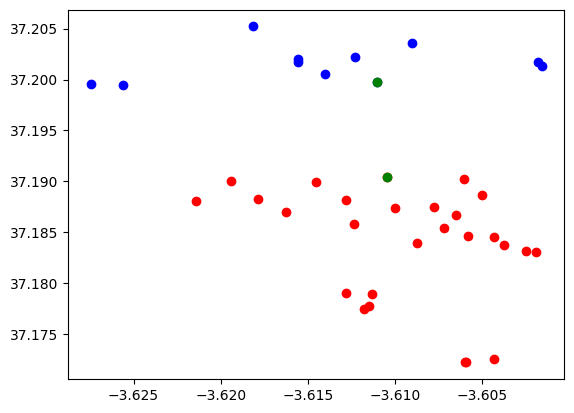

In [145]:
plt.scatter(final_data.loc[cluster_i, "lon"], final_data.loc[cluster_i, "lat"], color="red")
plt.scatter(final_data.loc[cluster_j, "lon"], final_data.loc[cluster_j, "lat"], color="blue")
plt.scatter(final_data.loc[cluster_i[min_distance_index[0]], "lon"], final_data.loc[cluster_i[min_distance_index[0]], "lat"], color="green")
plt.scatter(final_data.loc[cluster_j[min_distance_index[1]], "lon"], final_data.loc[cluster_j[min_distance_index[1]], "lat"], color="green")
plt.show()

# 2. Solve with QUBOSolver

In [13]:
#HERE EXECUTE QUBOSOLVER

## 2.1 Visualize QUBOSolver

In [14]:
def draw_line(df, line, color, map=None):
    means = df.mean()
    loc_coords = [means.iloc[1], means.iloc[2]]
    if map == None:
        map = folium.Map(location=loc_coords, zoom_start=8)
    # Get all connected positions from line adj matrix
    nonzero = np.nonzero(line)
    for i in range(len(nonzero[0])):
        indx1 = nonzero[0][i]
        indx2 = nonzero[1][i]

        pos_1 = df.iloc[indx1][['lat','lon']].values
        pos_2 = df.iloc[indx2][['lat','lon']].values
        folium.Marker(pos_1).add_to(map)
        folium.Marker(pos_2).add_to(map)
        colorline = folium.features.PolyLine([pos_1,pos_2], color=color)
        colorline.add_to(map)
    return map
line = np.genfromtxt(os.path.join("results", 'Line0.dat'))
map = draw_line(final_data, line, 'red')
line = np.genfromtxt(os.path.join("results", 'Line1.dat'))
map = draw_line(final_data, line, 'blue', map)
line = np.genfromtxt(os.path.join("results", 'Line2.dat'))
map = draw_line(final_data, line, 'green', map)
map